# Quora Questions - Text Classification

In [2]:
import pandas as pd
import matplotlib as plt

In [3]:
original_train = pd.read_csv('train.csv')
original_test = pd.read_csv('test.csv')

In [4]:
original_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
original_test.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


## Percentages of the two classes in the data
Two sample types:
* sincere
* insincere

In [6]:
num_sincere = float(len(original_train[original_train['target'] == 0]))
num_insincere = float(len(original_train[original_train['target'] == 1]))
print (num_sincere)
print (num_insincere)
print (num_sincere / (num_sincere + num_insincere) )
print (num_insincere / (num_sincere + num_insincere) )

1225312.0
80810.0
0.9381298224821265
0.06187017751787352


## Let's examine the data

In [7]:
original_train[original_train['target'] == 1].head()['question_text'][30] # definitively insincere

'Which babies are more sweeter to their parents? Dark skin babies or light skin babies?'

In [8]:
original_train[original_train['target'] == 1].head()['question_text'][110] # on the cusp - could be considered insincere bc "blacks" is not necessarily PC

"If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?"

In [9]:
original_train[original_train['target'] == 1].head()['question_text'][114] # lascivious and this is borderline incest

'I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?'

In [10]:
original_train[original_train['target'] == 1].head()['question_text'][115] # definitely insincere

'Which races have the smallest penis?'

In [11]:
original_train[original_train['target'] == 1].tail()['question_text'][1306093] # part 2 - incest

'How is it to have intimate relation with your cousin?'

In [12]:
original_train[original_train['target'] == 1].tail()['question_text'][1306099] # racist towards pakistani people

'Do pakis smell of curry and shit?'

In [13]:
original_train[original_train['target'] == 1].tail()['question_text'][1306094] # provocative and trying to make a statement

'Why is it when singers have lyrics about voices in their head, religious people say they hear god and anyone stating they are being targeted by voice to brain technology? Are they called delusional schizo?'

In [113]:
split_train1 = list(map(lambda x : x.lower().split(), original_train[original_train['target'] == 1]['question_text']))
split_train0 = list(map(lambda x : x.lower().split(), original_train[original_train['target'] == 0]['question_text']))

# Counts of Most Common First Words

In [ ]:
import matplotlib.pyplot as plt
most_common_words = {}
for question in split_train0:
    if question[0] in most_common_words:
        most_common_words[question[0]] += 1
    else:
        most_common_words[question[0]] = 1

sorted_by_desc_sincere = sorted(most_common_words.items(), key=lambda kv: kv[1], reverse=True)
top_7 = sorted_by_desc_sincere[0:7]

top_seven_words = [top_7[0][0], top_7[1][0], top_7[2][0], top_7[3][0], top_7[4][0], top_7[5][0], top_7[6][0]]
top_seven_counts = [top_7[0][1], top_7[1][1], top_7[2][1], top_7[3][1], top_7[4][1], top_7[5][1], top_7[6][1]]

plt.subplot(1,2,1)
plt.barh(top_seven_words, top_seven_counts, color = 'lightseagreen')
plt.title('Most Common First Words and their Counts', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('# of Questions', fontsize = 13)
plt.ylabel('First Word', fontsize = 14)
tick_val = [100000, 200000, 300000, 400000]
tick_lab = ['100k', '200k', '300k', '400k']
plt.xticks(tick_val,tick_lab)
plt.legend(['Sincere Questions'])


most_common_words = {}
for question in split_train1:
    if question[0] in most_common_words:
        most_common_words[question[0]] += 1
    else:
        most_common_words[question[0]] = 1

sorted_by_desc_insincere = sorted(most_common_words.items(), key=lambda kv: kv[1], reverse=True)
top_7 = sorted_by_desc_insincere[0:7]

top_seven_words = [top_7[0][0], top_7[1][0], top_7[2][0], top_7[3][0], top_7[4][0], top_7[5][0], top_7[6][0]]
top_seven_counts = [top_7[0][1], top_7[1][1], top_7[2][1], top_7[3][1], top_7[4][1], top_7[5][1], top_7[6][1]]

plt.subplot(1,2,2)
plt.barh(top_seven_words, top_seven_counts, color = 'salmon')
plt.title('Most Common First Words and their Counts', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('# of Questions', fontsize = 13)
plt.ylabel('First Word', fontsize = 14)
tick_val = [10000, 20000, 30000, 40000]
tick_lab = ['10k', '20k', '30k','40k']
plt.xticks(tick_val,tick_lab)
plt.legend(['Insincere Questions'])
plt.show()

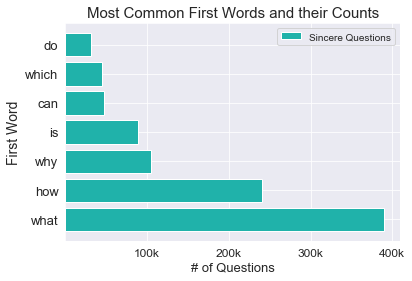

In [50]:
most_common_words = {}
for question in split_train0:
    if question[0] in most_common_words:
        most_common_words[question[0]] += 1
    else:
        most_common_words[question[0]] = 1

sorted_by_desc_sincere = sorted(most_common_words.items(), key=lambda kv: kv[1], reverse=True)
top_7 = sorted_by_desc_sincere[0:7]

top_seven_words = [top_7[0][0], top_7[1][0], top_7[2][0], top_7[3][0], top_7[4][0], top_7[5][0], top_7[6][0]]
top_seven_counts = [top_7[0][1], top_7[1][1], top_7[2][1], top_7[3][1], top_7[4][1], top_7[5][1], top_7[6][1]]

plt.barh(top_seven_words, top_seven_counts, color = 'lightseagreen')
plt.title('Most Common First Words and their Counts', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('# of Questions', fontsize = 13)
plt.ylabel('First Word', fontsize = 14)
tick_val = [100000, 200000, 300000, 400000]
tick_lab = ['100k', '200k', '300k', '400k']
plt.xticks(tick_val,tick_lab)
plt.legend(['Sincere Questions'])

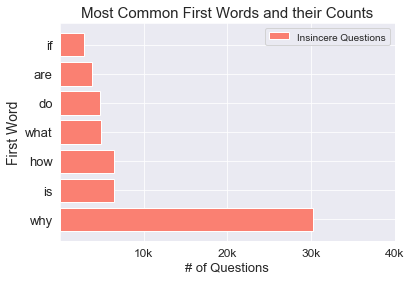

In [52]:
most_common_words = {}
for question in split_train1:
    if question[0] in most_common_words:
        most_common_words[question[0]] += 1
    else:
        most_common_words[question[0]] = 1

sorted_by_desc_insincere = sorted(most_common_words.items(), key=lambda kv: kv[1], reverse=True)
top_7 = sorted_by_desc_insincere[0:7]

top_seven_words = [top_7[0][0], top_7[1][0], top_7[2][0], top_7[3][0], top_7[4][0], top_7[5][0], top_7[6][0]]
top_seven_counts = [top_7[0][1], top_7[1][1], top_7[2][1], top_7[3][1], top_7[4][1], top_7[5][1], top_7[6][1]]

plt.barh(top_seven_words, top_seven_counts, color = 'salmon')
plt.title('Most Common First Words and their Counts', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('# of Questions', fontsize = 13)
plt.ylabel('First Word', fontsize = 14)
tick_val = [10000, 20000, 30000, 40000]
tick_lab = ['10k', '20k', '30k','40k']
plt.xticks(tick_val,tick_lab)
plt.legend(['Insincere Questions'])
plt.show()

In [53]:
# determine question type counts among sincere and sincere questions
search1 = 'why'
search2 = 'how'
search3 = 'what'
search4 = 'which'
search5 = 'do'

insincere_questions = [[] for _ in range(7)]
sincere_questions = [[] for _ in range(7)]
for sublist in split_train1:
    if sublist[0] == search1:
        insincere_questions[0].append(sublist)
    elif sublist[0] == search2:
        insincere_questions[1].append(sublist)
    elif sublist[0] == search3:
        insincere_questions[2].append(sublist)
    elif sublist[0] == search4:
        insincere_questions[3].append(sublist)
    elif sublist[0] == search5:
        insincere_questions[4].append(sublist)
for sublist in split_train0:
    if sublist[0] == search1:
        sincere_questions[0].append(sublist)
    elif sublist[0] == search2:
        sincere_questions[1].append(sublist)
    elif sublist[0] == search3:
        sincere_questions[2].append(sublist)
    elif sublist[0] == search4:
        sincere_questions[3].append(sublist)
    elif sublist[0] == search5:
        sincere_questions[4].append(sublist)

In [54]:
insincere_question_prop = [len(insincere_questions[0])/num_insincere, len(insincere_questions[1])/num_insincere, len(insincere_questions[2])/num_insincere, len(insincere_questions[3])/num_insincere, len(insincere_questions[4])/num_insincere]
sincere_question_prop = [len(sincere_questions[0])/num_sincere, len(sincere_questions[1])/num_sincere, len(sincere_questions[2])/num_sincere, len(sincere_questions[3])/num_sincere,len(sincere_questions[4])/num_sincere]
question_names = [search1, search2, search3, search4, search5]
print (question_names)
print (insincere_question_prop)
print (sincere_question_prop)

['why', 'how', 'what', 'which', 'do']
[0.3750402177948274, 0.07996535082291796, 0.060524687538670956, 0.005519118920925628, 0.0588169780967702]
[0.08513260296153143, 0.19587337755608367, 0.31855968112611316, 0.03651396542268418, 0.02511197148154919]


### Plot Question Proportions

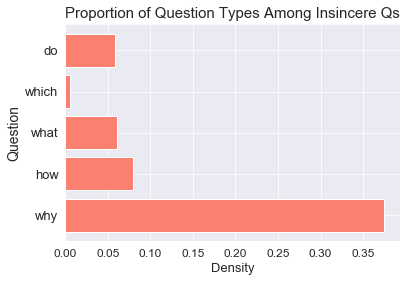

In [112]:
plt.barh(question_names, insincere_question_prop, color = 'salmon')
plt.title('Proportion of Question Types Among Insincere Qs', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('Density', fontsize = 13)
plt.ylabel('Question', fontsize = 14)
sns.set_style('darkgrid')
plt.show()

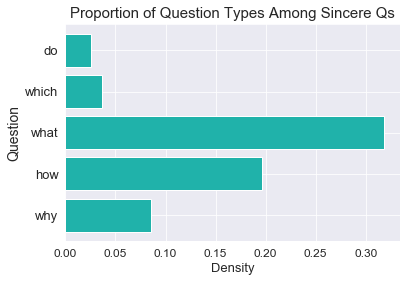

In [111]:
plt.barh(question_names, sincere_question_prop, color = 'lightseagreen')
plt.title('Proportion of Question Types Among Sincere Qs', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('Density', fontsize = 13)
plt.ylabel('Question', fontsize = 14)
sns.set_style('darkgrid')
plt.show()

#### Comment: 
People who ask insincere questions use significantly more "why" questions than any other question type. The "why" question assumes a statement to be true, which can be problematic in some cases. For many insincere "why" questions, the underlying assumption is inconclusive or is subjective, so the individual is more likely to be asserting an opinion rather than genuinely seeking the answer to a question.

In [21]:
# use this to determine common n-grams
#val = all(x in sublist for x in [search1]) # use this to find a combination of words in a sentence
from nltk.util import ngrams
search1 = 'jews'
search2 = 'and'
search3 = 'blacks'
questions = []
for sublist in split_train1:
    bigrams = list(ngrams(sublist, 3)) 
    bg = (search1, search2, search3)
    if bg in bigrams:
        questions.append(sublist)    

C:\Users\Artem\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: generator 'ngrams' raised StopIteration
  if __name__ == '__main__':


In [22]:
len(questions)

0

# Distribution of Question lengths

12.50853333681544


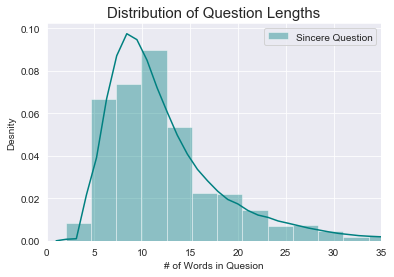

In [107]:
import seaborn as sns
import numpy as np
question_lengths_sincere = []
for question in split_train0:
    question_lengths_sincere.append(len(question))

print(np.mean(question_lengths_sincere))
sns.set_style('darkgrid')
fig1=sns.distplot(np.array(question_lengths_sincere),color="teal")
axes = fig1.axes
axes.set_xlim(0,35)
fig1.set_title('Distribution of Question Lengths', fontsize = 15)
fig1.set_xlabel('# of Words in Quesion')
fig1.set_ylabel('Desnity')
fig1.legend(['Sincere Question'])

17.277812151961392


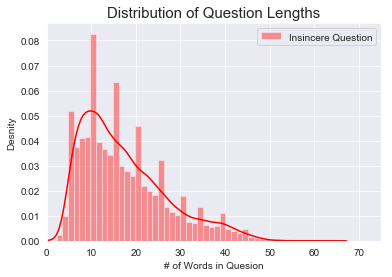

In [109]:
question_lengths_insincere = []
for question in split_train1:
    question_lengths_insincere.append(len(question))

print(np.mean(question_lengths_insincere))
sns.set_style('darkgrid')
fig1=sns.distplot(np.array(question_lengths_insincere),color="red")
axes = fig1.axes
axes.set_xlim(0,75)
fig1.set_title('Distribution of Question Lengths', fontsize = 15)
fig1.set_xlabel('# of Words in Quesion')
fig1.set_ylabel('Desnity')
fig1.legend(['Insincere Question'])

## Plot Common Word Frequencies

In [61]:
import itertools
concatenated_split_train1 = list(itertools.chain.from_iterable(split_train1))
concatenated_split_train0 = list(itertools.chain.from_iterable(split_train0))
concatenated_split_train1[:5]

['has', 'the', 'united', 'states', 'become']

In [62]:
from nltk.corpus import stopwords
s = stopwords.words('english')
concatenated_split_train1 = list(filter(lambda x : x not in s, concatenated_split_train1))  # filter out all stop words (e.g. pronouns, articles)
concatenated_split_train0 = list(filter(lambda x : x not in s, concatenated_split_train0))

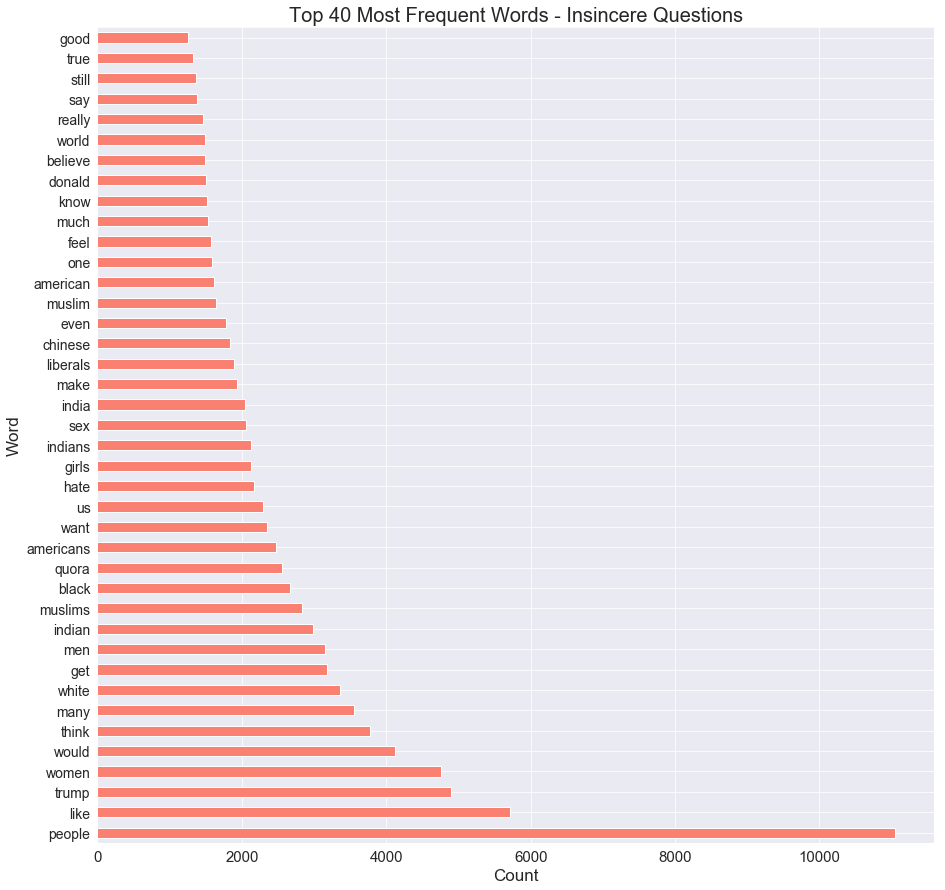

In [63]:
top = pd.Series(concatenated_split_train1).value_counts()[:40] # top 40 words 
plt.figure(figsize=(15,15))
plt.title("Top 40 Most Frequent Words - Insincere Questions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.ylabel('Word', fontsize = 17)
plt.xlabel('Count', fontsize = 17)
top.plot(kind='barh', color = 'salmon')
plt.show()

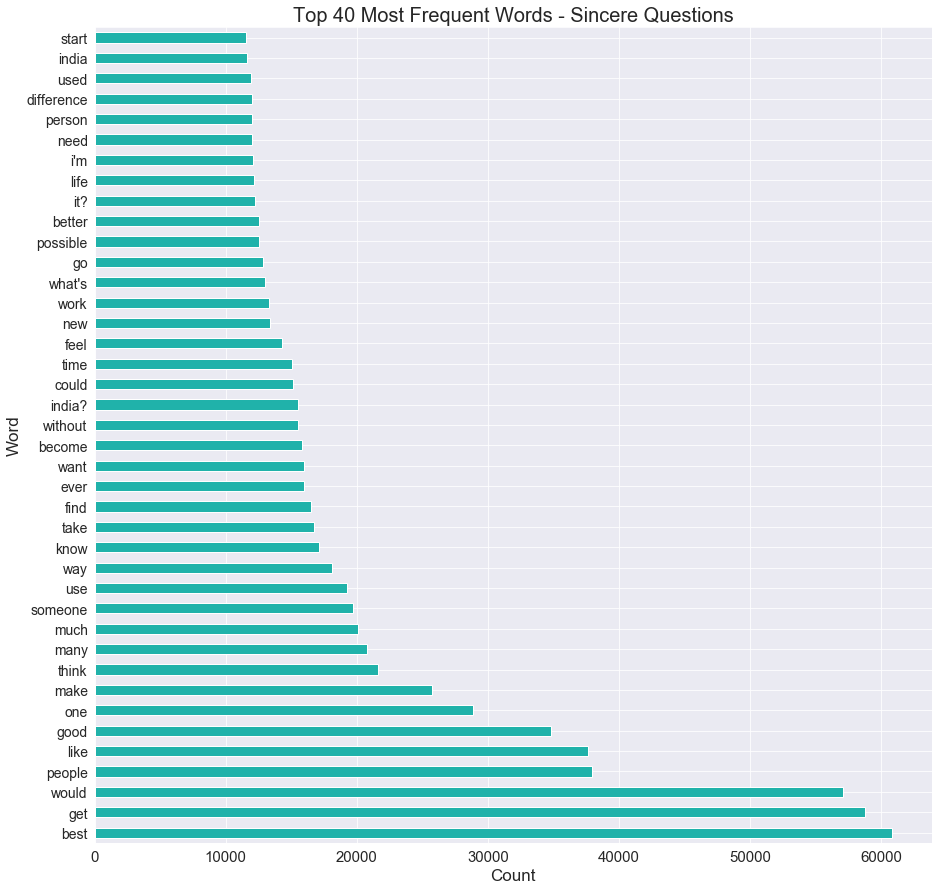

In [65]:
top = pd.Series(concatenated_split_train0).value_counts()[:40] # top 40 words 
plt.figure(figsize=(15,15))
plt.title("Top 40 Most Frequent Words - Sincere Questions", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=15)
plt.ylabel('Word', fontsize = 17)
plt.xlabel('Count', fontsize = 17)
top.plot(kind='barh', color = 'lightseagreen')
plt.show()

# Create Features for Training/Testing Data
Our input values will be constructed as follows:
* Features = columns
* Samples = rows

Let's concatenate the questions from the training data and testing data so that we can create the features based on the entire dataset. If we were to do this for the training and testing datasets individually, this would cause errors when we try to predict values from our testing dataset due to different number of dimensions in the number of columns in train compared to test data.

In [316]:
# concatenate train and test
import copy
X = copy.deepcopy(original_train['question_text'])
Z = copy.deepcopy(original_test['question_text'])
X = X.append(Z)
X= X.reset_index(drop = True)
X = np.array(list(map(lambda x: x.lower(), X)))# convert all the values to lowercase so that the stopwords can be filtered better
print X.shape # number of samples

(1362492L,)


In [317]:
print len(Z) # length of test dataset
print float(len(Z))/len(X) # proportion of the entire dataset that is testing data

56370
0.0413727199866


In [318]:
print float(len(X) - len(Z))/len(X) # proportion of the dataset that is training data

0.958627280013


#### Let's split our training dataset into train and validation

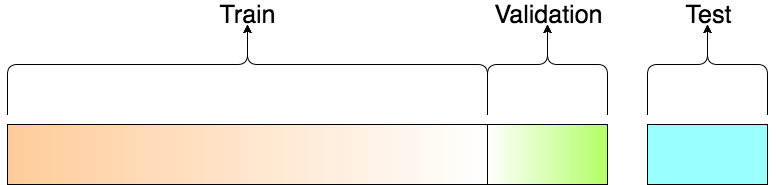

In [319]:
from IPython.display import Image
Image(filename='datasplit.png')
# this is how our data will be split

In [320]:
train_size = 1230000
print float(train_size)/len(X) # first 90% will be train data

valid_size = len(X) - len(Z)
print float(valid_size)/len(X) -  float(train_size)/len(X) # the remaining ~6% will be validation data

0.902757594173
0.0558696858404


#### Now, create features through word counts

In [321]:
# gets word counts of all unique words in the dataset - Bag of Words Representation (order doesn't matter)
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(stop_words = 'english') # remove stop_words (e.g. the, a, in, pronouns, etc.)
X_train_counts = count_vect.fit_transform(X)

In [322]:
print X[5]
print X_train_counts[5]
print X_train_counts.shape
# ()

is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?
  (0, 131520)	1
  (0, 180661)	1
  (0, 49324)	1
  (0, 21690)	1
  (0, 163923)	1
  (0, 74503)	1
(1362492, 199138)


#### TF-IDF (term frequency- inverse document frequency)
* f = frequency of the word in the sample question
* t = total number of documents
* n = number of documents the word is present in
* TF-IDF value = f * log(t/n)

For each question, the TF-IDF vector has TF-IDF value for each word among all the documents. This means there will be many 0s in the entries of the sample since several words will not be present in a given question. 

In [191]:
# most of the tf-idf values in this dataset are less than 1, but it's possible for them to exceed 1
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape # the shape here is the (num_samples, num_features) where num_features == unique words

(1362492, 199138)

In [192]:
X[5] # initial format of question

'is gaza slowly becoming auschwitz, dachau or treblinka for palestinians?'

In [193]:
samp = X_train_tfidf[5].todense() # 1 sample - the question converted into a vector of counts and then a vector of word frequencies
print samp
print samp[samp != 0.0][0,:]
print samp.shape

[[0. 0. 0. ... 0. 0. 0.]]
[[0.41783408 0.47241485 0.37168327 0.3099009  0.32646986 0.51134069]]
(1L, 199138L)


# Cross Validation

In [194]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_validate
scorer = ['accuracy', 'precision', 'recall', 'f1']
algorithm = BernoulliNB()
num_splits = 5
cv_results = cross_validate(algorithm, X_train_tfidf[:len(X) - len(Z)], original_train['target'], scoring = ('accuracy', 'precision', 'recall', 'f1'), cv = num_splits, return_train_score = True)

In [195]:
cv_results.keys()

['test_f1',
 'train_accuracy',
 'test_recall',
 'score_time',
 'train_f1',
 'fit_time',
 'train_precision',
 'test_accuracy',
 'train_recall',
 'test_precision']

In [196]:
num_splits = 5
print "Accuracy: " + str(sum(cv_results['test_accuracy'])/num_splits)
print "Precision: " + str(sum(cv_results['test_precision'])/num_splits)
print "Recall: " + str(sum(cv_results['test_recall'])/num_splits)
print "Harmonic Mean: " + str(sum(cv_results['test_f1'])/num_splits)

Accuracy: 0.9404489015230952
Precision: 0.51905518852574
Recall: 0.5101967578270016
Harmonic Mean: 0.514585477607519


# Don't worry about anything below here, I'm still making changes!

# Fit Model 
#### Bernoulli Naive Bayes Classifier 
Note: I used a BernoulliNB Classifier since other classifiers have a much longer run time or have poorer performance.

In [67]:
# This function displays the metrics for evaluation of the model.
from sklearn import metrics
def results(expected, actual):
    not_equal = actual[actual != expected]
    fn = not_equal[not_equal == 0] # false negatives
    accuracy = metrics.accuracy_score(expected, actual)
    recall = metrics.recall_score(expected, actual)
    precision = metrics.precision_score(expected, actual)
    harmonic_mean = 2 * (precision * recall) / (precision + recall)

    print 'Accuracy Score: ' + str(accuracy) # accuracy score based on our validation data 
    print 'Recall Score: ' + str(recall)
    print 'Precision Score: ' + str(precision)
    print 'Harmonic Mean: ' + str(harmonic_mean) + '\n'
    print 'Expected Insincere: ' + str(len(expected[expected == 1])) # insincere
    print 'Actual Number Insincere: ' + str(len(actual[actual == 1])) # insincere
    print 'Number of False Negatives: ' + str(len(fn))
    print 'Actual Number Sincere: ' + str(len(actual[actual == 0])) # sincere
    print 'Total: ' + str(len(expected))

In [68]:
# This function fits the data to a model and yields fitted values from the model
def model(alg, x, y, training_size, validation_size):
    classifier = alg.fit(x[:training_size], y[:training_size]) 
    validation = classifier.predict(x[training_size:validation_size]) 
    predicted = classifier.predict(X_train_tfidf[validation_size:]) # no target data available
    results(original_train['target'][training_size:validation_size], validation)
    return validation, predicted

In [69]:
# This function displays some of the sample questions and their predicted target values
import numpy as np
def display_samples(question_type, x_data, v_size, pred):
    if question_type:
        indices = np.where(pred == 1)
    else: 
        indices = np.where(pred == 0)
    print 'Here are a few samples with their target values.'
    count = 0
    for i in list(indices[0]):
        if count > 10: # display 10 samples
            break
        print x_data[v_size + i]
        print pred[i] 
        count = count + 1

#### Base Model 
For the base model, let's set all target values to 0, where 0 is the class for sincere questions, since the majority of questions are sincere. You'll see that the number of insincere predicted values is 0. This is because we didn't train on any insincere values. Also, the recall and precision scores are all 0. This is because we did not train on any data where the target value == 1, so it's not possible to have a true positive (value == 1), which is the numerator of the recall and precision scores. 
* recall = TP / TP + FN
* precision = TP / TP + FP

In [85]:
from sklearn.naive_bayes import BernoulliNB
algorithm = BernoulliNB()
y_base = list(copy.deepcopy(original_train['target'][:train_size]))
y_base = list(map(lambda x: x*0, y_base))
y_valid, y_pred = model(algorithm, X_train_tfidf, y_base, train_size, valid_size)   

Accuracy Score: 0.9379154515120465
Recall Score: 0.0
Precision Score: 0.0
Harmonic Mean: nan

Expected Insincere: 4726
Actual Number Insincere: 0
Number of False Negatives: 4726
Actual Number Sincere: 76122
Total: 76122


C:\Users\chris\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


#### Model With Observed Data
Now, let's see how the model performs on our observed data.

In [112]:
from sklearn.naive_bayes import BernoulliNB
algorithm = BernoulliNB()
y_valid, y_pred = model(algorithm, X_train_tfidf, original_train['target'], train_size, valid_size) 
# we want all of the proportions below to be as close to 1 as possible

Accuracy Score: 0.938677386300938
Recall Score: 0.5414727041895895
Precision Score: 0.5057312252964427
Harmonic Mean: 0.5229920294297976

Expected Insincere: 4726
Actual Number Insincere: 5060
Number of False Negatives: 2167
Actual Number Sincere: 71062
Total: 76122


In [234]:
# This function displays questions which were predicted to be sincere but Quora deems them to be insincere 
def display_false_negatives(expected, actual, input_questions, index):
    fn_indices = list(np.where((actual != expected) & (actual == 0))[0])
    print np.take(list(input_questions), fn_indices)[index]

In [235]:
display_false_negatives(original_train['target'][train_size:valid_size], y_valid, X[train_size:valid_size], index = 0)
# change the index to see different samples

Did President Obama insert a sleeper agent in the White House right before he left office?


#### Display Results
Let's see some of our samples from the testing data (includes input and output values)

In [ ]:
# display insincere samples
display_samples(1, X, valid_size, y_pred)

In [ ]:
# display sincere samples
display_samples(0, X, valid_size, y_pred)

# Future Work

#### To improve performance:

In [ ]:
# TODO: create features with n-grams (instead of using words as feature columns, use phrases with n words)

In [ ]:
# TODO: try different models if the runtime isn't too long
# try SVM, it generally has good performance for most classification problems

#### To explore and visualize the data:

In [ ]:
# bigram & trigram plots

In [ ]:
# implement ROC curve for each of our cross validation datasets

In [ ]:
# how many inscinere/sincere questions has a particular word?

In [ ]:
# which words produce the highest precision? recall? as in search for all the sentences with 'blacks' - call them insincere

In [ ]:
# TODO: group questions into themes: e.g. racism, sexism, homophobic, sexuality, religious intolerance, 
# prejudice towards immigrants, unproductive political criticism
# Visualize this data
# Show percentages of each type

# what we define these themes to be: 
    # look for all insincere questions that include a word denoting an ethnic group (e.g. blacks, jews, muslims)
    # look for all insincere questions that include a word denoting a sex(e.g. woman, women, man, men)
    # look for all insincere questions that include a word denoting a sexual preference(e.g gay, homo, fag, trans, transgender, LGBTQ)
    # look for all insincere questions that include a word denoting a religious group*( e.g. religious people, jews, muslims, christians)
    # look for all insincere questions that include a word denoting a sexual term (sexy, gay, kiss, etc.)
    # look for all insincere questions that include a word denoting immigrants (immigrants, fabs, fresh off the boat)
    # look for all insincere questions that include words(s) or phrases(s) denoting a politcal topic (liberals, libs, libtards, democrats, republicans, conservatives, nazis, neo-nazis, president's name, politcal commentators, etc.)

In [ ]:
# larger question for discussion section: although people make such discriminatory remarks, should we censor the online public?
# what are the implications of online censorship? 
    # Argument against censorship: people have dark, deep thoughts that may be contentious but perhaps they truly believe 
    # those thoughts and are genuinely curious. The online public could offer a medium to express and discuss those thoughts. 
    # One key advantage of online forums is the option to be anonymous, which makes one more open to share dark ideas. 